# Mean Flow Frequency Curve

__Description__: Calculates the mean flow frequency curve using [Bulletin 17C](https://pubs.usgs.gov/tm/04/b05/tm4b5.pdf) confidence limits calculated in [HEC-SSP](https://www.hec.usace.army.mil/software/hec-ssp/).

__Input__: [HEC-SSP](https://www.hec.usace.army.mil/software/hec-ssp/) .rpt files containing flow frequency data for a specific USGS Stream Gage calculated at a range of confidence limits.

__Output__: The mean flow frequency curve table (annual exceedance probability verses discharge).

*Acknowledgement*: This notebook was adapated from the Excel Workbook titled, "Calculating Mean (Expected) Flow Frequency Cruve Using Bulletin 17C Conf...," which was provided by david.a.margo@usace.army.mil from the USACE.

---
## Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from meanffc import*

### Parameters:
#### Site specific (papermill):

##### Make directory if it does not exist:

In [3]:
make_directories([outputs_dir], verbose)

C:\Users\sputnam\Desktop\MeanFFC\Outputs - created


#### Project specific:

In [4]:
standard_AEP = [0.9, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 5E-04, 2E-04, 1E-04, 5E-05, 2E-05, 1E-05, 5E-06, 2E-06, 1E-06]  # Selected standard reporting AEP values

### Data:
#### Identify the HEC-SSP results files:

In [5]:
inputs_dir = pl.Path(inputs_dir) 

ssp_results = list_ssp_files(inputs_dir, max_cl, verbose) 

01134500_60.rpt added to list
01134500_70.rpt added to list
01134500_80.rpt added to list
01134500_90.rpt added to list
01134500_95.rpt added to list
01134500_99.rpt added to list
01134500_995.rpt not added to list, above maximum confidence limit
01134500_999.rpt not added to list, above maximum confidence limit


##### Construct a summary table:

In [6]:
df = make_ssp_table(ssp_results, version) 
df.head(2)

,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99
AEP,,,,,,,,,,,,,
1.000000e-12,20087.3,26424.6,31288.4,39424.7,47586.8,56839.2,68209.2,83352.4,105733.4,144840.5,243084.1,409042.2,1526427.2
2.000000e-12,19426.3,25367.9,29901.6,37443.8,44967.1,53452.7,63829.0,77575.8,97769.5,132782.0,219690.6,364376.3,1310145.3


##### Check that discharge increases with decreasing AEP:

In [7]:
df = monotonic_test(df, adj_flows)

Discharge increases with decreasing annual exceedance probability for all confidence limits


##### Extract the confidence limits and annual exceedance probabilities:

In [8]:
CL = list(map(float, df.columns)) 

AEP = df.index 

---
## Calculate the Mean Flow Frequency Curve:
### Transform the HEC-SSP Results:

In [9]:
data = np.log10(df) 

CLz = zvar(CL) 

AEPz = zvar(AEP) 

#### Plot the transformed data to visually check for errors: 

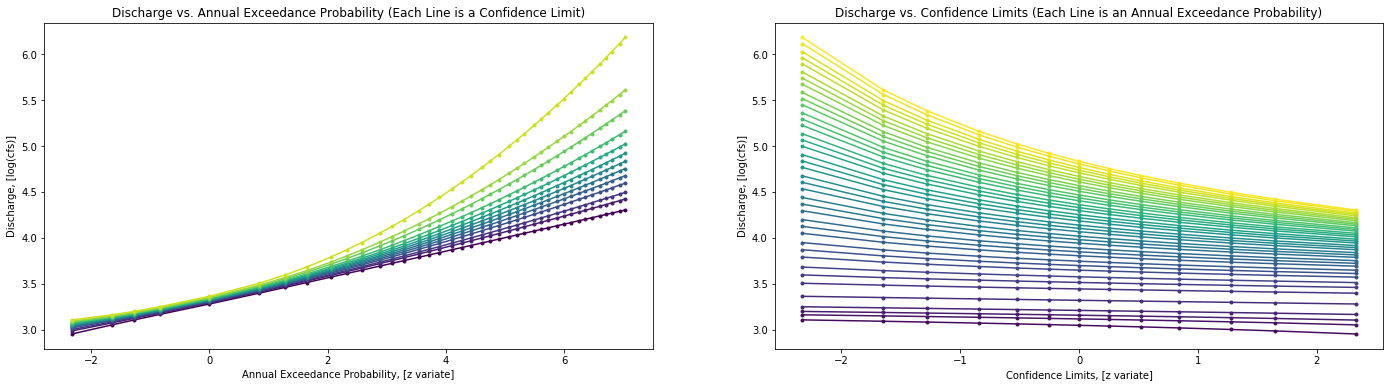

In [10]:
plot_ssp_transform(data, AEPz, CLz) 

### Determine the AEP for Each Flow and CL:
#### Bin the discharge and calculate the annual exceedance probability:

In [11]:
Q = binq(data)

res = interp_aep(data, Q, CLz, AEPz, Extrapolate)

##### Plot the results:

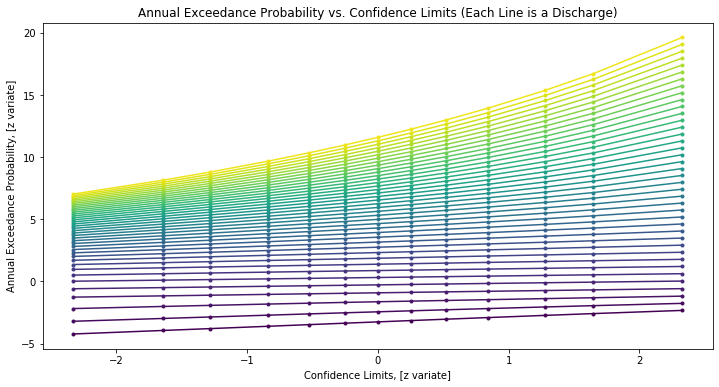

In [12]:
plot_ssp_interp(res)

#### Take the inverse of the standard normal z variate of the AEP:

In [13]:
restrans = zvar_inv(res, CL)

##### Plot the results:

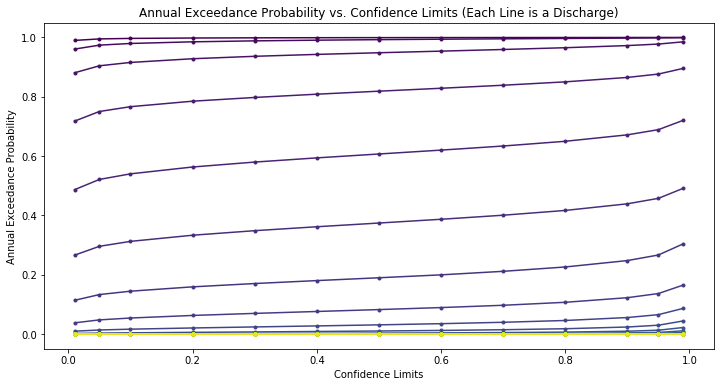

In [14]:
plot_ssp_interptrans(restrans)

#### Calculate the Mean (Expected Value) of the AEP:

In [15]:
AEPm = mean_aep(restrans, exclude_tails) 

##### Transform the mean AEP:

In [16]:
AEPmz = zvar(AEPm) 

##### Plot the results:

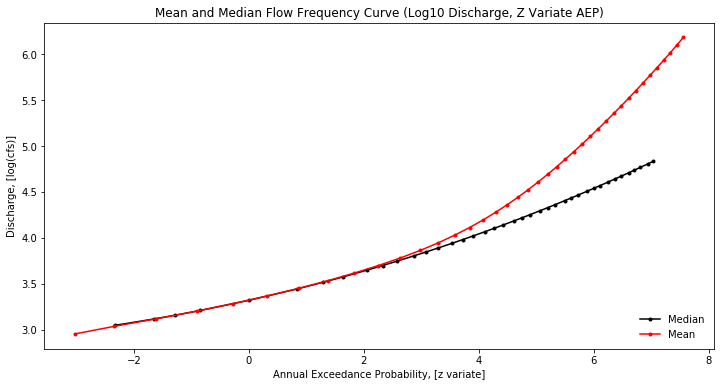

In [17]:
plot_ssp_meanmed(AEPz, data, AEPmz, Q) 

---
## Construct a Summary Table and Save:
### Transform the Standard AEPs and Initialize a Summary Table:

In [18]:
standard_AEPz = zvar(standard_AEP) 

table = ffc_summary(standard_AEP, standard_AEPz) 

### Calculate the Mean and Median Flow:

In [19]:
table['Q_Mean_cfs'] = np.round(10**table['AEPz'].apply(interp_q(AEPmz, Q)), round_decimals)

table['Q_Median_cfs'] = np.round(10**table['AEPz'].apply(interp_q(AEPz, np.array(data['0.5']))), round_decimals)

#### Save the Results:

In [20]:
mean_curve_table = table.copy().drop(columns=['AEPz'])

outputs_dir = pl.Path(outputs_dir)

mean_curve_table.to_csv(outputs_dir/'MeanCurve_{}.csv'.format(gage_ID)) 

sb.glue('mean_curve', mean_curve_table.to_dict())

mean_curve_table.head(2)

,Q_Mean_cfs,Q_Median_cfs
AEP,,
0.9,1431.9,1433.3
0.5,2095.3,2083.5


#### Plot the Results (Static):

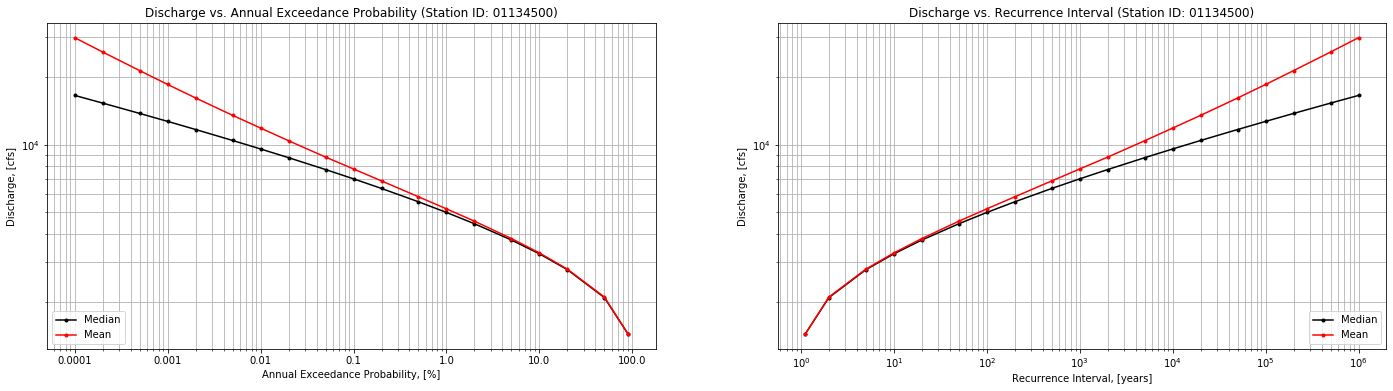

In [21]:
plot_ssp_meanmedffc(table, gage_ID) 

#### Plot the Results (Interactive):

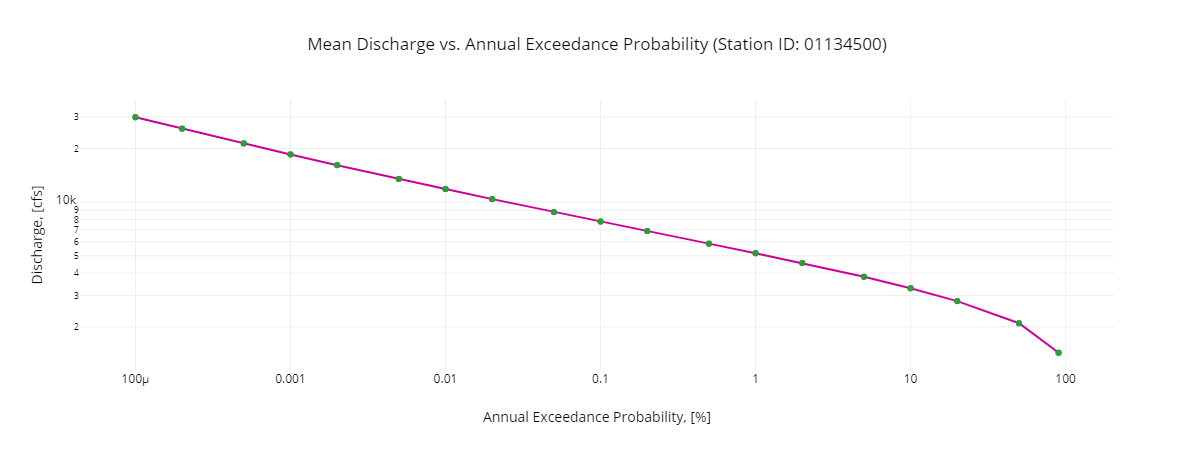

In [22]:
plotly_ssp_meanffc(table, gage_ID)

---
## End